# DNN: analysis with Keras of 2D data

In [121]:
import os
import tensorflow as tf

os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["TF_NUM_INTEROP_THREADS"] = str(os.cpu_count())
os.environ["TF_NUM_INTRAOP_THREADS"] = str(os.cpu_count())

tf.config.threading.set_inter_op_parallelism_threads(os.cpu_count())
tf.config.threading.set_intra_op_parallelism_threads(os.cpu_count())



In [122]:
import numpy as np
import keras.optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner
import matplotlib as mpl
import matplotlib.pyplot as plt
# default font
plt.rcParams['font.size'] = 13

from sklearn.preprocessing import StandardScaler

%run useful.py

# training data
perc_train = 0.8

## Read data

(2000, 8)
8
[1.83918812 2.04560279 5.67725029 5.95544703 9.6451452  6.53177097
 7.48906638 6.53569871] 1
[7.47714809 9.61306736 0.08388298 1.06444377 2.98703714 6.56411183
 8.09812553 8.72175914] 0
[9.64647597 7.23685347 6.42475328 7.17453621 4.67599007 3.25584678
 4.39644606 7.29689083] 0
[9.94014586 6.76873712 7.90822518 1.70914258 0.26849276 8.00370244
 9.03722538 0.2467621 ] 0
[4.91747318 5.26255167 5.9636601  0.51957545 8.95089528 7.2826618
 8.18350011 5.00222753] 1
data: 2000
train: 1600


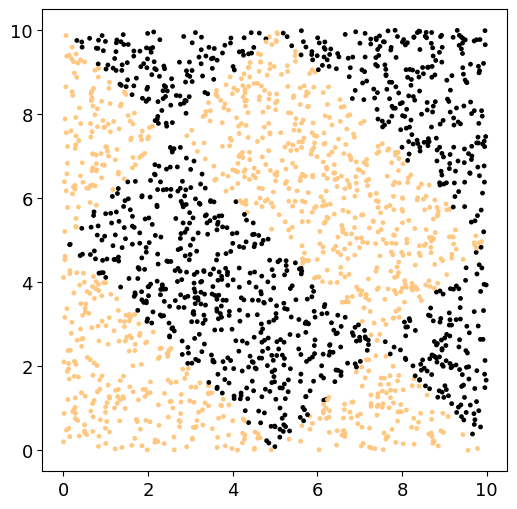

In [123]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8
# span of each component
B=10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
print(x.shape)
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)


# dim. of a sample
L = len(x[0])
print(L)

for i in range(5):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plot_data(x,y)

## Standardize data

In [124]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Split training and test data

In [125]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
(x_test,y_test) = (y_train, x_train)
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 1600 	 Validation: 400


# GIOCODE
Da code of Joe

## Define the model with Keras / Tensorflow

SGD con nesterov TRUE

In [ ]:
def build_model(hp):
    model = Sequential()
    # Input layer
    model.add(Dense(L, input_shape=(L,), activation='relu'))
    # 3 not so hidden layers
    for layer_num in range(1, 4):
        model.add(Dense(20, activation=hp.Choice(f'activation_{layer_num}', ['sigmoid','relu','elu'])))
        model.add(Dropout(hp.Float(f'Dropout_{layer_num}', min_value=0, max_value=0.2, step=0.1, sampling='linear')))
    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    learning_rate = hp.Choice('lr', [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
    hyper_optimizer = hp.Choice('optimizer', ['sgd_nesterov', 'adam', 'RMSprop', 'adamax','adagrad','adadelta','adamw', 'adafactor','nadam']) 
    # Configure the chosen optimizer
    if hyper_optimizer == 'sgd_nesterov':
        hyper_optimizer = keras.optimizers.SGD(
            learning_rate=learning_rate, 
            nesterov=True
        )
    else: hyper_optimizer = hyper_optimizer
    model.compile(loss='binary_crossentropy', optimizer=hyper_optimizer, metrics=["accuracy"],)
    # SGD doesn't use Nesterov by default...
    return model

In [127]:
build_model(keras_tuner.HyperParameters())

/home/margherita/src/ambiente/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential_1, built=True>

In [128]:
tuner = keras_tuner.RandomSearch(hypermodel=build_model, objective="val_accuracy", max_trials=10, executions_per_trial=2,  directory='randomsearchstuff_ex1', project_name='ex1')
tuner.search(x_train, y_train, epochs=400, validation_data=(x_valid, y_valid))

Trial 10 Complete [00h 01m 19s]
val_accuracy: 0.5362499952316284

Best val_accuracy So Far: 0.9800000190734863
Total elapsed time: 00h 13m 53s


In [129]:
models = tuner.get_best_models(num_models=10)

tuner.results_summary()

best_model = models[0]
best_model.summary()

/home/margherita/src/ambiente/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 23 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/margherita/src/ambiente/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/margherita/src/ambiente/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/margherita/src/ambiente/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable

Results summary
Results in randomsearchstuff_ex1/ex1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
activation_1: elu
Dropout_1: 0.0
activation_2: sigmoid
Dropout_2: 0.0
activation_3: relu
Dropout_3: 0.2
lr: 1e-06
optimizer: nadam
Score: 0.9800000190734863

Trial 00 summary
Hyperparameters:
activation_1: elu
Dropout_1: 0.2
activation_2: relu
Dropout_2: 0.2
activation_3: sigmoid
Dropout_3: 0.0
lr: 0.0001
optimizer: adam
Score: 0.9624999761581421

Trial 04 summary
Hyperparameters:
activation_1: elu
Dropout_1: 0.0
activation_2: sigmoid
Dropout_2: 0.2
activation_3: relu
Dropout_3: 0.0
lr: 0.1
optimizer: sgd_nesterov
Score: 0.9624999761581421

Trial 07 summary
Hyperparameters:
activation_1: sigmoid
Dropout_1: 0.1
activation_2: sigmoid
Dropout_2: 0.0
activation_3: sigmoid
Dropout_3: 0.0
lr: 0.001
optimizer: nadam
Score: 0.9600000083446503

Trial 01 summary
Hyperparameters:
activation_1: sigmoid
Dropout_1: 0.2
activation_2: sigmoid
Dr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113 (4.35 KB)

 Trainable params: 1,113 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [130]:
nepoch = 10
fit = best_model.fit(x_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_valid,y_valid),
               verbose=2)

Epoch 1/10
32/32 - 1s - 35ms/step - accuracy: 0.9681 - loss: 0.0558 - val_accuracy: 0.9775 - val_loss: 0.0708
Epoch 2/10
32/32 - 0s - 3ms/step - accuracy: 0.9794 - loss: 0.0548 - val_accuracy: 0.9750 - val_loss: 0.0735
Epoch 3/10
32/32 - 0s - 3ms/step - accuracy: 0.9744 - loss: 0.0509 - val_accuracy: 0.9775 - val_loss: 0.0730
Epoch 4/10
32/32 - 0s - 2ms/step - accuracy: 0.9775 - loss: 0.0520 - val_accuracy: 0.9775 - val_loss: 0.0713
Epoch 5/10
32/32 - 0s - 3ms/step - accuracy: 0.9781 - loss: 0.0484 - val_accuracy: 0.9775 - val_loss: 0.0740
Epoch 6/10
32/32 - 0s - 2ms/step - accuracy: 0.9812 - loss: 0.0466 - val_accuracy: 0.9800 - val_loss: 0.0715
Epoch 7/10
32/32 - 0s - 2ms/step - accuracy: 0.9756 - loss: 0.0495 - val_accuracy: 0.9800 - val_loss: 0.0699
Epoch 8/10
32/32 - 0s - 3ms/step - accuracy: 0.9781 - loss: 0.0505 - val_accuracy: 0.9825 - val_loss: 0.0779
Epoch 9/10
32/32 - 0s - 2ms/step - accuracy: 0.9681 - loss: 0.0575 - val_accuracy: 0.9750 - val_loss: 0.0796
Epoch 10/10
32/32 

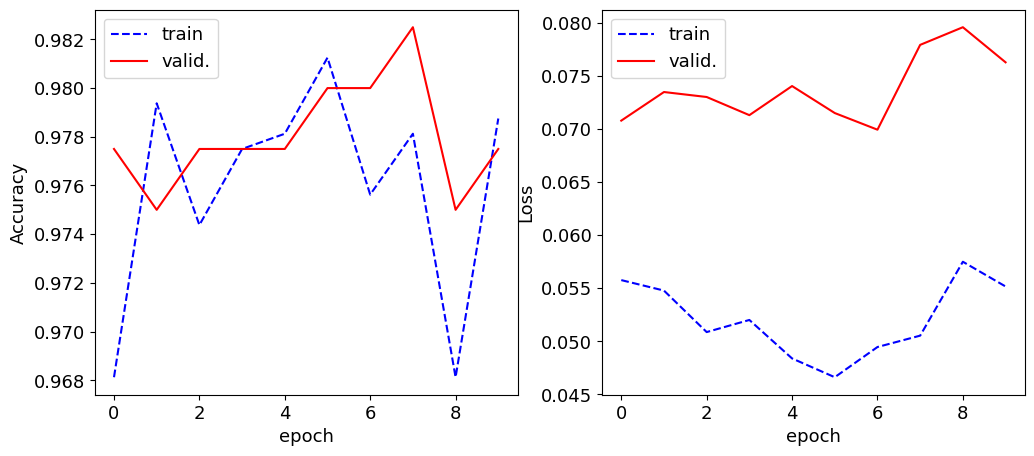

In [131]:
fig,AX=plt.subplots(1,2,figsize=(12,5.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b",ls="--")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b",ls="--")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

## Grid to show preditions

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step


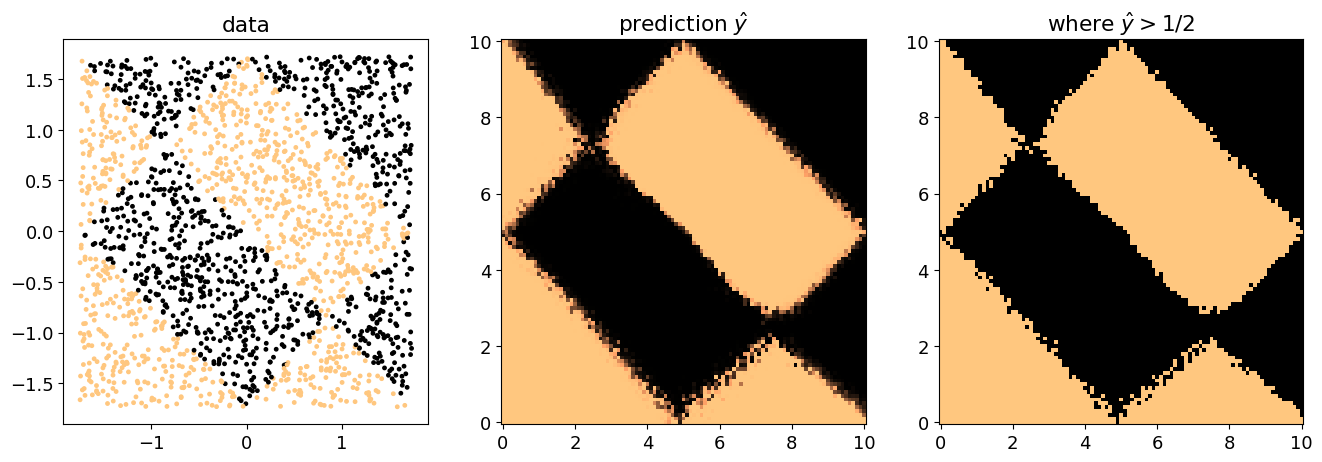

remember: these ar 2 out of L=8 dimensions, of which L-2 contain random noise


In [132]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = best_model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()
print(f"remember: these ar 2 out of L={L} dimensions, of which L-2 contain random noise")

PART 2

In [ ]:
models = tuner.get_best_models(num_models=10)

tuner.results_summary()
best_model = models[0]
best_model.summary()

Results summary
Results in randomsearchstuff_ex1/ex1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
activation_1: elu
Dropout_1: 0.0
activation_2: sigmoid
Dropout_2: 0.2
activation_3: sigmoid
Dropout_3: 0.2
lr: 0.0001
optimizer: nadam


/home/margherita/src/ambiente/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/margherita/src/ambiente/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 23 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113 (4.35 KB)

 Trainable params: 1,113 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import random

perc_train = 0.8
TYPE=3
L=8
N = len(x)
N_train = int(perc_train * N)

N_aug=9000
B=10

# ORIGINAL
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")

# REDUCTED
index= random.sample(range(len(x)),int(0.5*x.shape[0]))
x_reducted = x[index]
y_reducted = y[index]
#plot_data(x_reducted,y_reducted)

# INCREASED
np.random.seed(1)
x_increased=np.random.random((N_aug,L))*B #number between (0,1) * width of data sample
y_increased=list(np.zeros(N_aug))
for i in range(N_aug):
    y_increased[i]=NF(x_increased[i],B,TYPE)
#plot_data(x_new,y_new)



In [134]:
x_prova=np.loadtxt(filename("data",L,TYPE), delimiter=' ')
#distanza media sulla prima feature:
x_sorted=sorted(x_prova[:,0])
dist=[]
for i in range(1,N):
    dist.append(x_sorted[i]-x_sorted[i-1])
std=np.mean(dist)
for i in range(0,N):
    lista=[]
    for j in range(L):
        lista.append(np.random.normal(loc=x[i,j],scale=10*std))
    x_prova=np.append(x_prova,[lista],axis=0)

y_prova=list(np.zeros(x_prova.shape[0]))
for i in range(x_prova.shape[0]):
    y_prova[i]=NF(x_prova[i],B,TYPE)

print(len(y_prova))
print(len(y))

#plot_data(x,y)
#plot_data(x_prova,y_prova)


4000
2000


In [ ]:
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss


def prepare_data(x,y):
    """
    Does rescaling and divides into training and test set.
    """
    x_mean = np.mean(x,axis=0)
    x_std  = np.std(x,axis=0)
    print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
    x = Standardize(x,x_mean,x_std)
    print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))
    ## Split training and test data
    (x_train, y_train) = (x[0:N_train],y[0:N_train])
    (x_valid, y_valid) = (x[N_train:],y[N_train:])
    (x_test,y_test) = (y_train, x_train)
    print("Train:",len(x_train),"\t Validation:",len(x_valid))
    return x_train,y_train,x_valid,y_valid,x_test,y_test

In [ ]:
def train_data(X,Y):
    '''
    STO DANDO PER SCONTATO CHE SIA STATO TROVATO E RUNNATO IL BEST MODEL
    '''
    nepoch = 10
    x_train,y_train,x_valid,y_valid,x_test,y_test=prepare_data(X,Y)
    fit = best_model.fit(x_train, y_train,
                epochs = nepoch, batch_size = 50,
                validation_data=(x_valid,y_valid),
                verbose=2)

    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],label="train",c="b",ls="--")
    ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],label="train",c="b",ls="--")
    ax.plot(fit.history['val_loss'],label="valid.",c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.legend()
